## App Store Reivew analysis - App name
---------------

## 개요

### 문서 목적
- **App name** 앱에 대한 분석 리포트 작성을 위해 문서를 만들었습니다.

### 분석 대상
- **구글 플레이 스토어에 고객이 작성한 리뷰 정보**
  - user_name : 이용자 이름(닉네임)
  - user_app_rating : 별점(1~5)
  - user_review_date : 리뷰 작성 날짜
  - company_comment_date : 답변 작성 날짜
  - comment : 리뷰 내용
  - company_answer_check : 답변 여부


### 분석 일시
- 데이터 분석 시작 : 분석 날짜
- 데이터 구성 날짜 : YYYY-MM-DD to YYYY-MM_DD
  - 2019년 이전의 데이터가 수집되더라도 분석 할 때는 2019년 01월 01일 이후의 데이터만 다룹니다.
  - 분석 목적이 앱에 대한 분석 리포트이며 빠르게 업데이트 되는 흐름에 맞추기 위해서 입니다.
  - 다만, 필요에 의해 수정 될 수 있습니다.

### 분석 방법
1. 데이터 확인
  - 데이터 전처리
  - 컬럼 확인
2. 시간 기록에 따른 데이터 분석
  - 시간에 따른 별점 변화(별점은 1 ~ 5의 값을 가진다)
  - 요일에 따른 리뷰 분석
  - 답변 시간차(고객 응대 소요 시간)
3. 리뷰 내용에 대한 자연어 분석
  - 리뷰 내용을 Topic modeling로 구성하고 시각화
  - 별점에 따라 주요 키워드 분석 진행

### 분석 환경, 분석자
- 분석 환경
  - language
      - python3
  - library
      - [khaiii](https://github.com/kakao/khaiii) : 카카오에서 제공하는 형태소 분석기
      - [gensim](https://radimrehurek.com/gensim/) : 자연어 처리 방법 중 LDA - Topic Modeling 사용
      - 시각화, 데이터 분석을 위한 Python library

- 분석자
  - github : https://github.com/timetobye


### 안내 사항
- **분석에 사용 될 리뷰 정보는 직접 크롤링**을 하여 데이터 셋을 구성하였습니다.
- 2018년 10월 한국 시장 기준으로 Android(72.2%) vs IOS(27.8%)의 점유율을 갖고 있어서 구글 플레이 스토어를 선택하였습니다.
  - [참고 링크 - Difference in Mobile OS Market Share is notable in US, Japan and South Korea](https://en.appa.pe/whitepaper/2018/)
  
--------------------------------------------

### 분석 결과

- 작성하기
----------------

### code

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pylab as plt
import matplotlib.style as style
import seaborn as sns
import khaiii
import missingno as msno
import warnings
import re
import calendar
import gensim
import os
import pyLDAvis
from collections import Counter
from datetime import datetime
from gensim import corpora
from gensim import models
from gensim.models import LdaModel
from pyLDAvis import gensim as gensimvis
from pyLDAvis import display
from pyLDAvis import save_html as lda_visualization
from khaiii import KhaiiiApi
from matplotlib import font_manager, rc
apple = font_manager.FontProperties(fname = '/Library/Fonts/AppleGothic.ttf').get_name()
rc('font', family = apple)

warnings.filterwarnings('ignore')
style.use('fivethirtyeight')
pyLDAvis.enable_notebook()
%matplotlib inline

## 1. 데이터 확인

### 데이터 전처리 - Preprocessing

In [2]:
# read_csv to make dataframe

google_playstore_user_review_orginal_df = pd.read_csv('yogiyo_app_user_reviews_20200330_041226.csv')
google_playstore_user_review_orginal_df.head(10)

,user_name,user_app_rating,user_review_date,company_comment_date,user_comment,company_answer_check
0,우랄라대마왕,5,2020년 3월 25일,no_answer,항상 편하게 잘이용하고있습니다. 다만 쿠폰제도 문제가 있다고 생각해요 이달 주문 건...,no_answer
1,김재헌,5,2020년 3월 26일,2020년 3월 27일,👍정말 좋아요👍 배달도 완전 빠르고 할인까지! 크.. 이렇게 좋은앱이 이제야 나온게...,answer
2,봄나비,2,2020년 3월 15일,no_answer,현장에서 직접 카드나 현금 결제시 아무런 혜택이 없더군요. 받은 쿠폰은 많으나 쓸모...,no_answer
3,sujiniii036 S,1,2020년 3월 23일,no_answer,카드 결제 할때 자꾸 튕겨요. KG이시니스에서 해당카드앱 최종결제 완료 뜨고 요기요...,no_answer
4,김선청,5,2020년 3월 30일,no_answer,혼자사는사람이나 같이 사는 사람들한테는 유용한 어플이고 맛있어요,no_answer
5,서유영,5,2020년 3월 30일,no_answer,"사랑해요, 이벤트 많이 열어주세용",no_answer
6,황혜수,5,2020년 3월 30일,no_answer,좋아요.,no_answer
7,김기대,5,2020년 3월 30일,no_answer,최고입니다.,no_answer
8,이성훈,5,2020년 3월 30일,no_answer,편리하네요,no_answer
9,YC S,1,2020년 3월 29일,no_answer,배달 라이더들 좀 똑바로 교육시키세요,no_answer


In [3]:
# check dataframe info

google_playstore_user_review_orginal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4204 entries, 0 to 4203
Data columns (total 6 columns):
user_name               4204 non-null object
user_app_rating         4204 non-null int64
user_review_date        4204 non-null object
company_comment_date    4204 non-null object
user_comment            4204 non-null object
company_answer_check    4204 non-null object
dtypes: int64(1), object(5)
memory usage: 197.1+ KB


In [4]:
google_playstore_user_review_orginal_df.rename(columns = {'comment' : 'user_comment'}, inplace=True)

### check-point

- 크롤링 과정에서도 첫 3개가 시간 순서 정렬과 관계없이 항상 고정된 값으로 구성되어 있었다.
  - 해당 부분에 대해서는 날짜 기준으로 정렬할 것
- 중복 값이 있는 경우를 방지하기 위해 중복 체크도 진행한다.
- 날짜 정보도 사용하기 쉽게 YYYY-MM-DD 형식으로 처리 할 것
- 요일 정보를 얻기 위해 작업을 진행 할 것

In [8]:
def sort_dataframe(df):
    sorted_df = df.sort_values(by='user_review_date', ascending=False).reset_index(drop=True)
    
    return sorted_df

def drop_duplicate_dataframe(df):
    drop_dp_df = df.drop_duplicates()
    drop_dp_df.reset_index(drop=True, inplace=True)
    
    return drop_dp_df

def get_weekday(date):
    if date == 'no_answer':
        return date
    
    weekday_info_dict = {
        0 : 'Mon',
        1 : 'Tue',
        2 : 'Wed',
        3 : 'Thu',
        4 : 'Fri',
        5 : 'Sat',
        6 : 'Sun'
    }
    
    regex = re.compile(r'[0-9]+')
    get_regex_date = regex.findall(date)
    
    year, month, day = [int(value) for value in get_regex_date]
    
    weekday_number = calendar.weekday(year, month, day)
    weekday_value = weekday_info_dict[weekday_number]
    
    return weekday_value

def convert_date_format(date):
    if date == 'no_answer':
        return date
    
    regex = re.compile(r'[0-9]+')
    get_regex_date = regex.findall(date)

    if len(get_regex_date[1]) == 1:
        get_regex_date[1] = '0' + get_regex_date[1]
        
    if len(get_regex_date[2]) == 1:
        get_regex_date[2] = '0' + get_regex_date[2]
    
    join_string = '-'
    convert_date = join_string.join(get_regex_date)
    
    return convert_date

def arrange_user_comment(df):
    df = df[['user_name', 'user_app_rating', 'user_review_date', 'company_comment_date', 'user_review_weekday', 'user_comment', 'company_answer_check']]
#     df = df[(df['user_review_date']>='2019-01-01') & (df['user_review_date']<='2019-12-31')]
    
    return df

def user_data_preprocessing(google_playstore_user_review_orginal_df):
    # sort user_review_date
    sorted_user_review_df = sort_dataframe(google_playstore_user_review_orginal_df)

    # drop duplicate
    drop_dp_user_review_df = drop_duplicate_dataframe(sorted_user_review_df)

    # get weekday from user_review_date
    drop_dp_user_review_df['user_review_weekday'] = drop_dp_user_review_df['user_review_date'].apply(get_weekday)

    # convert_date_format for applying function in pandas
    drop_dp_user_review_df['user_review_date'] = drop_dp_user_review_df['user_review_date'].apply(convert_date_format)
    drop_dp_user_review_df['company_comment_date'] = drop_dp_user_review_df['company_comment_date'].apply(convert_date_format)

    # arrange_user_comment
    arranged_user_review_df = arrange_user_comment(drop_dp_user_review_df)
    
    return arranged_user_review_df

In [9]:
arranged_user_review_df = user_data_preprocessing(google_playstore_user_review_orginal_df)
arranged_user_review_df.head()

,user_name,user_app_rating,user_review_date,company_comment_date,user_review_weekday,user_comment,company_answer_check
0,김중안,5,2020-03-09,no_answer,Mon,좋아요,no_answer
1,반려치,1,2020-03-09,no_answer,Mon,요청사항에 문앞에두고 전화주세요좀 없애주세요 지들이 그리 요청사항 선택해놓고 전화하...,no_answer
2,junyoung seo,5,2020-03-09,no_answer,Mon,좋네요 역시 요기오,no_answer
3,김우진,5,2020-03-09,no_answer,Mon,ㅇㅇㅇ샷,no_answer
4,ARTOY,5,2020-03-09,no_answer,Mon,매번 잘쓰고있어요ㅎㅎ,no_answer


--------------------------------

## Basic EDA

### check data info & missingvalue

In [10]:
arranged_user_review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4200 entries, 0 to 4199
Data columns (total 7 columns):
user_name               4200 non-null object
user_app_rating         4200 non-null int64
user_review_date        4200 non-null object
company_comment_date    4200 non-null object
user_review_weekday     4200 non-null object
user_comment            4200 non-null object
company_answer_check    4200 non-null object
dtypes: int64(1), object(6)
memory usage: 229.8+ KB


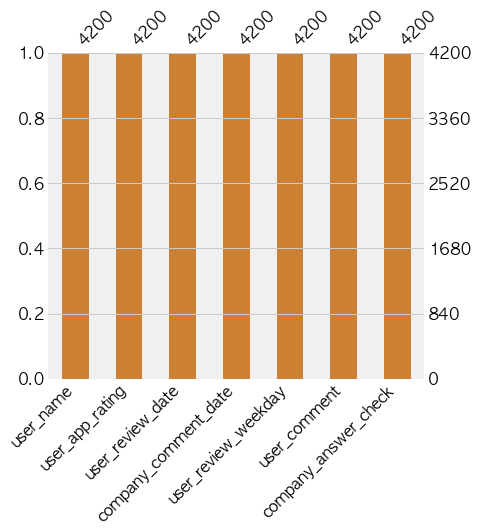

In [11]:
#msno.bar

msno.bar(df=arranged_user_review_df.iloc[:, :], figsize=(6, 6), color=(0.8, 0.5, 0.2))
plt.show()

### 수집된 데이터의 기간

In [12]:
max_date = arranged_user_review_df['user_review_date'].max()
min_date = arranged_user_review_df['user_review_date'].min()

print(f'수집된 데이터를 살펴보니 이용자가 리뷰를 작성한 날짜는 {min_date} 부터 {max_date} 까지 입니다.')

수집된 데이터를 살펴보니 이용자가 리뷰를 작성한 날짜는 2020-02-09 부터 2020-03-30 까지 입니다.


In [13]:
def arrange_count_value(df, column_name):
    df_value_count = df[column_name].value_counts()
    
    df_count = df_value_count.rename_axis('user').reset_index(name='writing_count')
    sorted_df_count = df_count.sort_values('writing_count', ascending=False)
    arranged_df = sorted_df_count.reset_index(drop=True)

    return arranged_df

### 어떤 요일에 많이 달았을까?

In [14]:
weekday_count = arrange_count_value(arranged_user_review_df, 'user_review_weekday')
weekday_count.rename(columns={'user' : 'weekday'}, inplace=True)

In [15]:
weekday_count

,weekday,writing_count
0,Sun,736
1,Sat,634
2,Wed,608
3,Thu,596
4,Mon,570
5,Fri,557
6,Tue,499


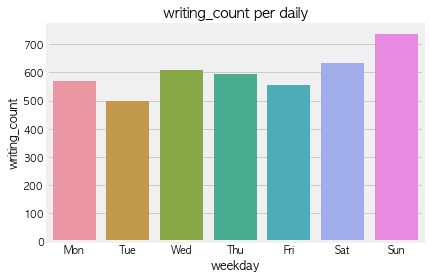

In [16]:
# draw weekday graph

weekday_order_list = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
sns.barplot(x='weekday', y='writing_count', data=weekday_count, order=weekday_order_list)
plt.title('writing_count per daily')
plt.show()

## 요일에 따른 리뷰 분석

In [17]:
weekday_user_review_df = arranged_user_review_df[['user_app_rating', 'user_review_weekday']]
weekday_user_review_df.head()

,user_app_rating,user_review_weekday
0,5,Mon
1,1,Mon
2,5,Mon
3,5,Mon
4,5,Mon


In [18]:
# crosstab for checking two catagory

crosstab_result = pd.crosstab(weekday_user_review_df['user_app_rating'], weekday_user_review_df['user_review_weekday'], margins=True).style.background_gradient(cmap='summer_r')
crosstab_result

user_review_weekday,Fri,Mon,Sat,Sun,Thu,Tue,Wed,All
user_app_rating,,,,,,,,
1,26,40,31,46,35,37,32,247
2,5,3,12,13,7,6,6,52
3,21,29,27,42,27,17,28,191
4,85,71,88,116,73,68,81,582
5,420,427,476,519,454,371,461,3128
All,557,570,634,736,596,499,608,4200


In [19]:
# crosstab with ratio

crosstab_result = pd.crosstab(weekday_user_review_df['user_app_rating'], weekday_user_review_df['user_review_weekday'], normalize=True).T
crosstab_result

user_app_rating,1,2,3,4,5
user_review_weekday,,,,,
Fri,0.006190,0.001190,0.005000,0.020238,0.100000
Mon,0.009524,0.000714,0.006905,0.016905,0.101667
Sat,0.007381,0.002857,0.006429,0.020952,0.113333
Sun,0.010952,0.003095,0.010000,0.027619,0.123571
Thu,0.008333,0.001667,0.006429,0.017381,0.108095
Tue,0.008810,0.001429,0.004048,0.016190,0.088333
Wed,0.007619,0.001429,0.006667,0.019286,0.109762


In [20]:
def draw_heatmap(weekday_user_review_df, weekday_order_list):
    crosstab_result = pd.crosstab(weekday_user_review_df['user_app_rating'], weekday_user_review_df['user_review_weekday'], normalize=True).T
    crosstab_result = crosstab_result.reindex(index=weekday_order_list)
    
    plt.figure(figsize=(10, 5))
    sns.heatmap(crosstab_result, cmap="YlGnBu", annot=True, cbar=True, fmt='0.3g')
    plt.title('user_app_rating per weekday')
    plt.show()

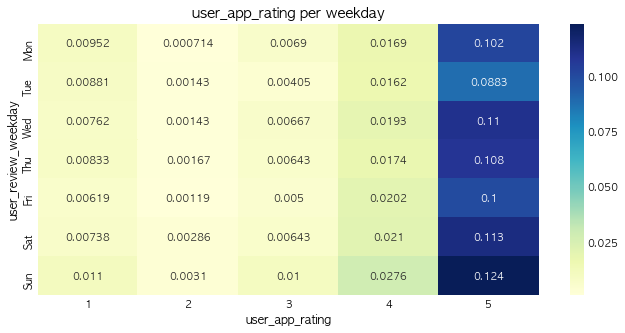

In [21]:
draw_heatmap(weekday_user_review_df, weekday_order_list)

### 리뷰를 작성한 사람들은 누구일까요?

In [22]:
arrange_count_df = arrange_count_value(arranged_user_review_df, 'user_name')
arrange_count_df.head(10)

,user,writing_count
0,Google 사용자,16
1,김성호,4
2,이윤정,4
3,김정훈,4
4,김승현,4
5,이원호,3
6,김성현,3
7,김지영,3
8,김은정,3
9,김도연,3


- **Google 사용자**가 다수가 나온 이유를 살펴보니, 앱스토어에서 실제로 리뷰 작성자의 이름이 Google 사용자라고 되어 있다.
  - 탈퇴를 했거나, 혹은 익명의 아이디를 처리하는 방식으로 판단된다.
  - 결론적으로 Google 사용자를 잠시 제외하고 살펴보겠다.

In [23]:
drop_arrange_count_df = arrange_count_df[arrange_count_df['user']!='Google 사용자'].reset_index(drop=True)

# get user_review_count and ratio
groupby_user_review_count = drop_arrange_count_df.groupby('writing_count', as_index=False).count()
groupby_user_review_count.rename(columns = {'user' : 'count'}, inplace=True)
groupby_user_review_count['ratio'] = round(groupby_user_review_count['count']/sum(groupby_user_review_count['count']), 2)
groupby_user_review_count

,writing_count,count,ratio
0,1,3815,0.96
1,2,142,0.04
2,3,23,0.01
3,4,4,0.00


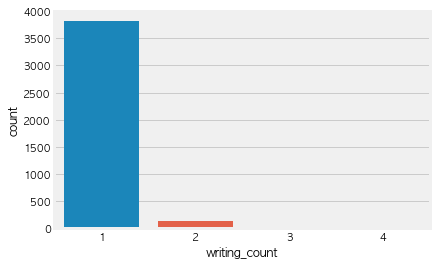

In [24]:
# 이용자들은 개인당 몇 번이나 리뷰를 달았을까?

sns.countplot(x='writing_count', data = drop_arrange_count_df)

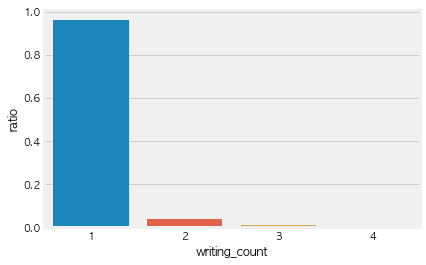

In [25]:
# 이용자들은 개인당 몇 번이나 리뷰를 달았을까?(비율)

sns.barplot(x='writing_count', y='ratio', data = groupby_user_review_count)

### 별점 분포는 어떻게 되어 있을까?

In [26]:
app_rating_count = arrange_count_value(arranged_user_review_df, 'user_app_rating')
app_rating_count.rename(columns={'user' : 'app_rating', 'writing_count' : 'rating_count'}, inplace=True)
app_rating_count

,app_rating,rating_count
0,5,3128
1,4,582
2,1,247
3,3,191
4,2,52


In [27]:
app_rating_count['ratio'] = round(app_rating_count['rating_count']/sum(app_rating_count['rating_count']), 2)
app_rating_count

,app_rating,rating_count,ratio
0,5,3128,0.74
1,4,582,0.14
2,1,247,0.06
3,3,191,0.05
4,2,52,0.01


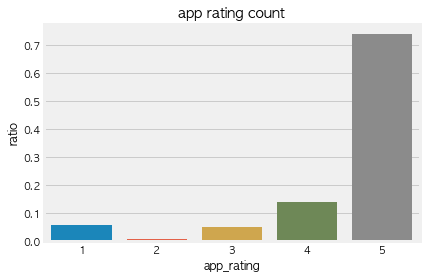

In [28]:
# draw app_rating graph

app_rating_order_list = [1, 2, 3, 4, 5]
sns.barplot(x='app_rating', y='ratio', data=app_rating_count, order=app_rating_order_list)
plt.title('app rating count')
plt.show()

-----------------------

## 2. 시간 기록에 따른 데이터 분석

### 시간에 따른 별점 변화
- 여러가지 접근 방법이 있겠지만, 일별 평균 별점 값을 그래프로 그려서 확인해본다.
- 2019년 01월 1일 이후만 확인

In [29]:
app_rating_with_date = arranged_user_review_df[['user_app_rating', 'user_review_date']]
average_app_rating_per_daily = app_rating_with_date.groupby('user_review_date', as_index=False).mean()
average_app_rating_per_daily = average_app_rating_per_daily[average_app_rating_per_daily['user_review_date']>='2019-01-01'] # defalt 2019-01-01
app_rating_with_date.head()

,user_app_rating,user_review_date
0,5,2020-03-09
1,1,2020-03-09
2,5,2020-03-09
3,5,2020-03-09
4,5,2020-03-09


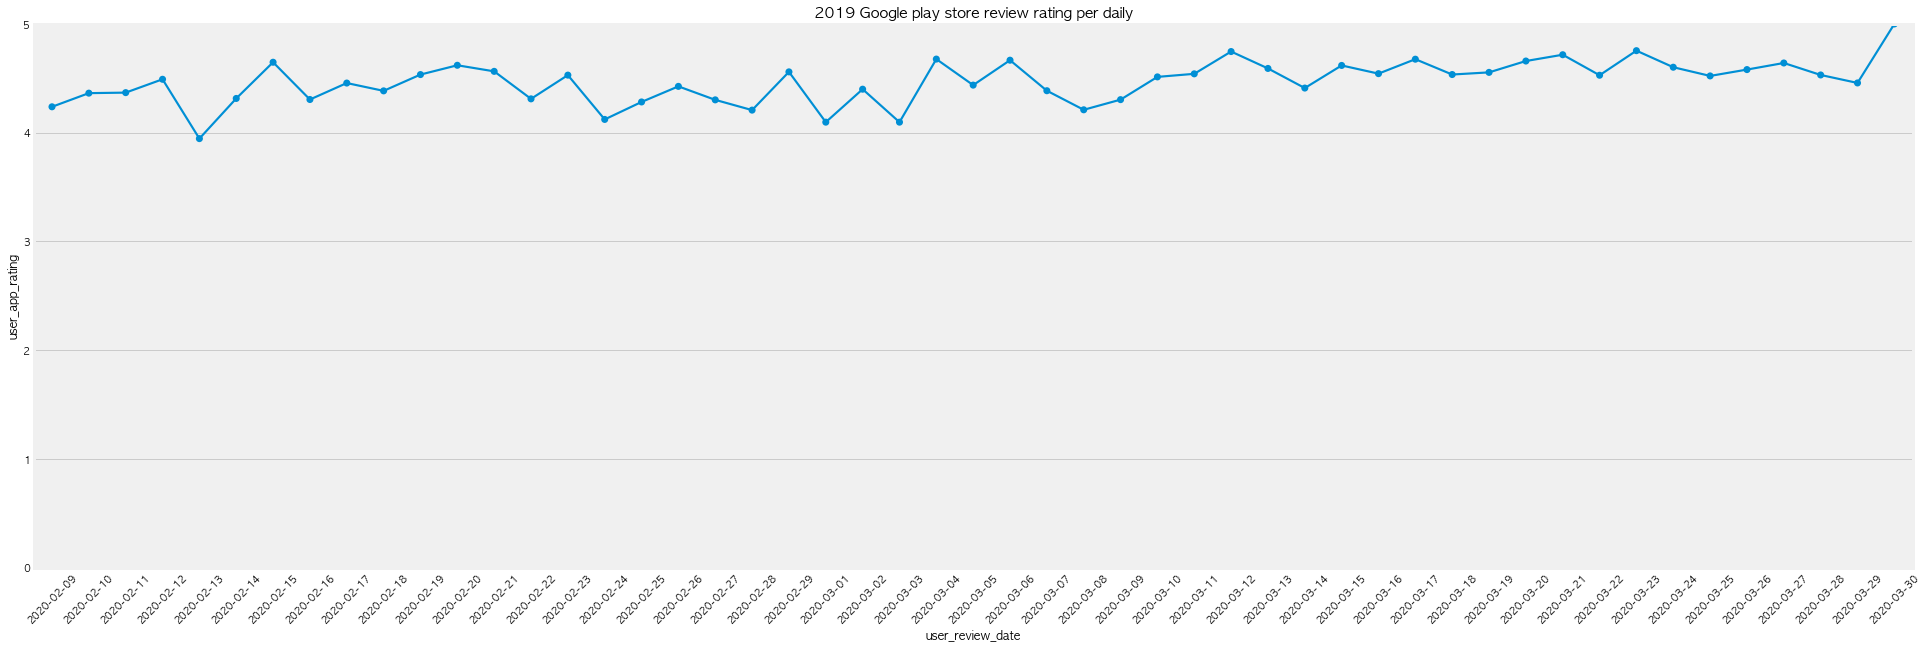

In [30]:
# draw graph : 2019 Google play store review rating per daily

plt.figure(figsize = (30, 10))
sns.pointplot(x='user_review_date', y='user_app_rating', data=average_app_rating_per_daily, scale=0.3)
plt.xticks(rotation=45)
plt.title('2019 Google play store review rating per daily', fontsize = 15)
plt.ylim(0, 5)
plt.show()

In [31]:
# check statics

app_rating_with_date.describe()

,user_app_rating
count,4200.000000
mean,4.498095
std,1.058875
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


### 월별 분석
- 월별 분석을 위해 간단한 전처리 진행 후 분석한다.

In [32]:
app_rating_with_monthly = arranged_user_review_df[['user_app_rating', 'user_review_date']]
app_rating_with_monthly.head()

,user_app_rating,user_review_date
0,5,2020-03-09
1,1,2020-03-09
2,5,2020-03-09
3,5,2020-03-09
4,5,2020-03-09


In [33]:
def extract_year_month(date):
    year_month = date[0:7]
    
    return year_month

In [34]:
app_rating_with_monthly['year_month'] = app_rating_with_monthly['user_review_date'].apply(extract_year_month)
app_rating_with_monthly.head()

,user_app_rating,user_review_date,year_month
0,5,2020-03-09,2020-03
1,1,2020-03-09,2020-03
2,5,2020-03-09,2020-03
3,5,2020-03-09,2020-03
4,5,2020-03-09,2020-03


In [48]:
app_rating_with_year_month = app_rating_with_monthly[(app_rating_with_monthly['year_month']>='2019-01')&(app_rating_with_monthly['year_month']<='2020-12')]
app_rating_with_year_month.sort_values('user_review_date', ascending=False, inplace=True)
app_rating_with_year_month.reset_index(drop=True, inplace=True)

In [49]:
app_rating_with_year_month.head()

,user_app_rating,user_review_date,year_month
0,5,2020-03-30,2020-03
1,5,2020-03-30,2020-03
2,5,2020-03-30,2020-03
3,5,2020-03-30,2020-03
4,5,2020-03-30,2020-03


In [50]:
monthly_result = app_rating_with_year_month.groupby('year_month', as_index=False).mean()
monthly_result

,year_month,user_app_rating
0,2020-02,4.386282
1,2020-03,4.538163


In [51]:
monthly_result.describe()

,user_app_rating
count,2.000000
mean,4.462222
std,0.107396
min,4.386282
25%,4.424252
50%,4.462222
75%,4.500193
max,4.538163


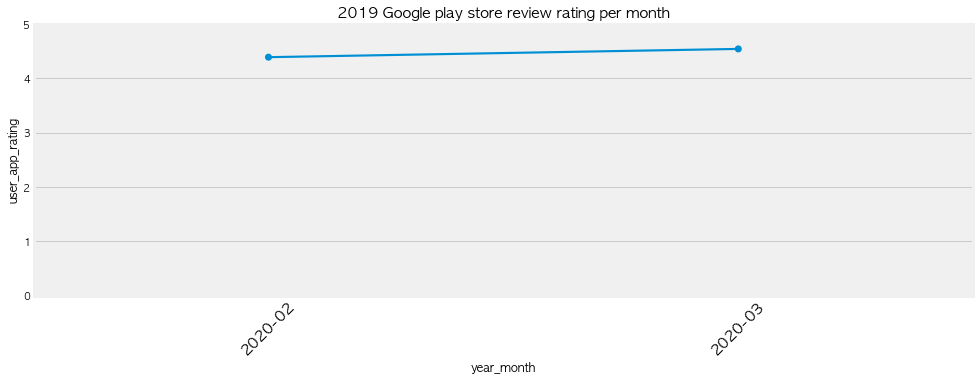

In [52]:
# draw graph : 2019 Google play store review rating per month

plt.figure(figsize = (15, 5))
sns.pointplot(x='year_month', y='user_app_rating', data=monthly_result, scale=0.3)
plt.xticks(rotation=45, fontsize = 15)
plt.title('2019 Google play store review rating per month', fontsize = 15)
plt.ylim(0, 5)
plt.show()

---------------------------------

### 답변 응답 비율
- 사용자의 리뷰에 꼭 답변을 달아야 할 필요는 없지만, 어느 정도는 필요할 것으로 보이기 때문에 이 항목을 살펴본다.
- 전체 평점과 평점이 2점 이하인 항목으로 나누어서 살펴본다.

In [37]:
def get_review_response_graph(series, title_type):
    if title_type == 'all':
        title_string = '전체 평점 리뷰 답변 비율'
    else:
        title_string = '2점 이하 평점 리뷰 답변 비율'
    
    plt.figure(figsize = (8, 5))
    sns.barplot(series.index, series.values)
    plt.title(title_string)
    plt.show()

In [38]:
review_response_all_rating = arranged_user_review_df['company_answer_check'].value_counts(normalize=True)
review_response_low_rating = arranged_user_review_df[arranged_user_review_df['user_app_rating']<=2]['company_answer_check'].value_counts(normalize=True)

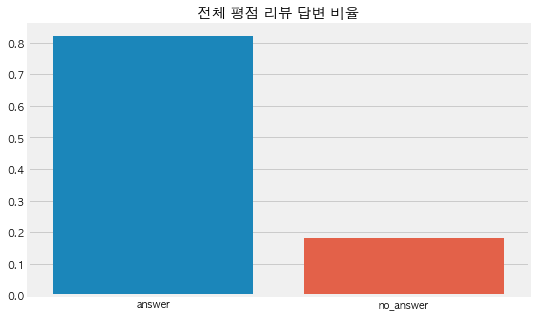

In [39]:
get_review_response_graph(review_response_all_rating, 'all')

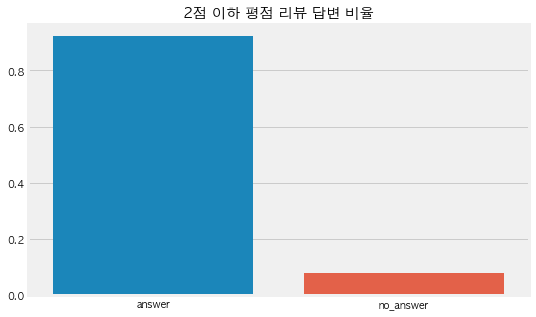

In [40]:
get_review_response_graph(review_response_low_rating, 'low')

### 리뷰에 답변이 얼마만에 달릴까?
- 이용자들에게 답변하는 날짜는 이용자가 리뷰를 달은 날짜와 얼마나 차이가 날까?
  - 답변을 달지 않은 날은 제외하고 파악해보도록 하자
  - 아쉽게도 시, 분, 초는 플레이스토어에서 구할 수가 없어서 day 기준으로 판단한다.
- 리플을 굳이 달지 않아도 되는 항목이 있을 수도 있으니, 리플을 달은 것 vs 달지 않은 것에 대한 비교는 하지 않는다.

In [41]:
reply_date_df = arranged_user_review_df[['user_app_rating', 'user_review_date', 'company_comment_date']]
reply_date_df_with_answer = reply_date_df[reply_date_df['company_comment_date']!='no_answer'].reset_index(drop=True)
reply_date_df_with_answer.head()

,user_app_rating,user_review_date,company_comment_date
0,1,2019-09-09,2019-10-24
1,5,2019-09-09,2019-09-10
2,1,2019-09-09,2019-09-10
3,1,2019-09-08,2019-09-10
4,3,2019-09-07,2019-09-10


In [42]:
def convert_string_to_datetime_format(date):
    convert_date = datetime.strptime(date, "%Y-%m-%d")
    
    return convert_date


def calculate_time_deleta(df, column_name_1, column_name2):
    time_delta_list = []
    for index, row in df.iterrows():
        time_delta_value = row[column_name2] - row[column_name_1]
        time_delta_day = time_delta_value.days
        
        time_delta_list.append(time_delta_day)
        
    df['reply_time'] = time_delta_list
    
    return df

In [43]:
# convert string to datetime_format

reply_date_df_with_answer_columns = ['user_review_date', 'company_comment_date']

for column in reply_date_df_with_answer_columns:
    reply_date_df_with_answer[column] = reply_date_df_with_answer[column].apply(convert_string_to_datetime_format)
    

# calculate time delta

cal_reply_time_delta_df = calculate_time_deleta(reply_date_df_with_answer, 'user_review_date', 'company_comment_date')
cal_reply_time_delta_df.head()

,user_app_rating,user_review_date,company_comment_date,reply_time
0,1,2019-09-09,2019-10-24,45
1,5,2019-09-09,2019-09-10,1
2,1,2019-09-09,2019-09-10,1
3,1,2019-09-08,2019-09-10,2
4,3,2019-09-07,2019-09-10,3


In [44]:
def arrange_count_value(df, column_name):
    df_value_count = df[column_name].value_counts()
    
    df_count = df_value_count.rename_axis('reply_time').reset_index(name='count')
    sorted_df_count = df_count.sort_values('reply_time', ascending=True)
    arranged_df = sorted_df_count.reset_index(drop=True)
    arranged_df = sorted_df_count[sorted_df_count['reply_time']>=0].reset_index(drop=True)
    
    return arranged_df

In [45]:
# 답변 시간이 음수가 되는 경우가 종종 있다. 
# 시스템 문제로 파악 되었으나, 그게 아니고 하나의 글에 리플을 여러번 달 경우 처음 답변과의 시차가 발생해서 나타난 결과이다.
# 이번 분석에서는 음수가 되는 경우는 제외하고 시각화 하겠다.

reply_time_df = arrange_count_value(cal_reply_time_delta_df, 'reply_time')
reply_time_df['ratio'] = reply_time_df['count'] / sum(reply_time_df['count'])
reply_time_df['cumsum_ratio'] = reply_time_df['ratio'].cumsum()
reply_time_df = reply_time_df[reply_time_df['reply_time']<=20]

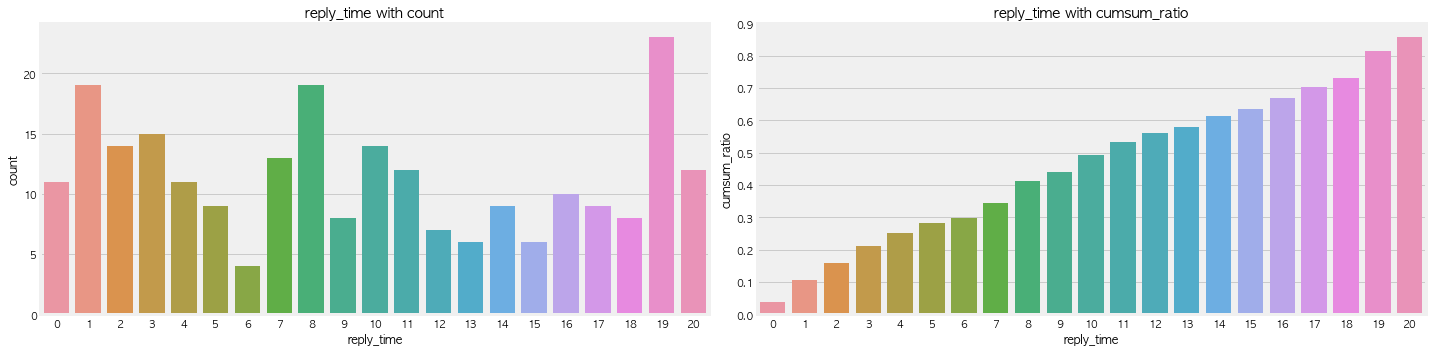

In [46]:
# draw reply_time graph
def draw_count_and_ratio_graph(df):
    y_position = 1.02
    f, ax = plt.subplots(1,2, figsize=(20, 5))

    sns.barplot(x='reply_time', y='count', data=df, ax=ax[0])
    ax[0].set_title(f'reply_time with count')

    sns.barplot(x='reply_time', y='cumsum_ratio', data=df, ax=ax[1])
    ax[1].set_title(f'reply_time with cumsum_ratio')
    
    plt.tight_layout()
    plt.show()

draw_count_and_ratio_graph(reply_time_df)

In [47]:
# filter data set

reply_date_df = arranged_user_review_df[['user_app_rating', 'user_review_date', 'company_comment_date']]
reply_date_df_with_low_rating = reply_date_df[(reply_date_df['company_comment_date']!='no_answer')&(reply_date_df['user_app_rating']<=2)].reset_index(drop=True)
reply_date_df_with_low_rating.head()


# convert string to datetime_format

reply_date_df_with_low_rating_columns = list(reply_date_df_with_low_rating.columns)

for column in reply_date_df_with_low_rating_columns:
    if column == "user_app_rating":
        continue

    reply_date_df_with_low_rating[column] = reply_date_df_with_low_rating[column].apply(convert_string_to_datetime_format)
    

# calculate time delta

cal_reply_time_delta_df = calculate_time_deleta(reply_date_df_with_low_rating, 'user_review_date', 'company_comment_date')


# calculate ratio

reply_time_df = arrange_count_value(cal_reply_time_delta_df, 'reply_time')
reply_time_df['ratio'] = reply_time_df['count'] / sum(reply_time_df['count'])
reply_time_df['cumsum_ratio'] = reply_time_df['ratio'].cumsum()
reply_time_df = reply_time_df[reply_time_df['reply_time']<=20]

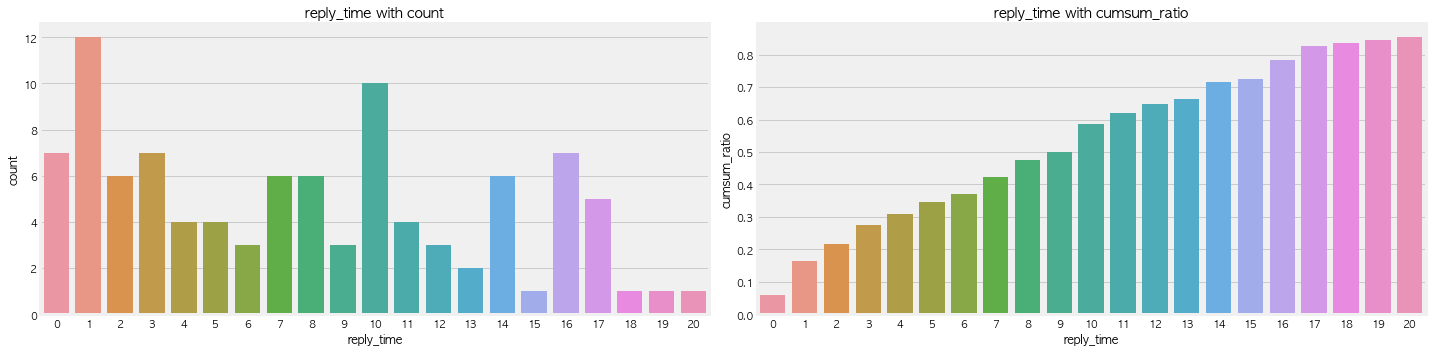

In [48]:
draw_count_and_ratio_graph(reply_time_df)

### 3. 리뷰 내용에 대한 자연어 간단 분석
- KAKAO KHAiii를 이용하여 명사 추출
- 추출된 자료를 바탕으로 Topic modeling로 구성하고 시각화
- 별점에 따라 주요 키워드 분석 진행

In [40]:
def extract_noun(word_object_list):
    extracted_word_noun_list = []
    
    for i, word_object in enumerate(word_object_list):
        word_object_morphs = word_object.morphs
        
        for word in word_object_morphs:
            if word.tag in ['NNG', 'NNP']:
                extracted_word_noun_list.append(word.lex)
    
    return extracted_word_noun_list


def execute_khaiii(user_comment_list):
    sentence_analyze_components = []
    kha_api = KhaiiiApi()
    
    for i, user_comment in enumerate(user_comment_list):
        word_object_list = []
        user_comment_analyze_objects = kha_api.analyze(user_comment)
        
        for user_comment_analyze_object in user_comment_analyze_objects:
            word_object_list.append(user_comment_analyze_object)
            
        extracted_noun_list = extract_noun(word_object_list)  
        sentence_analyze_components.append(extracted_noun_list)
        
#         if i == 1:
#             break
    
    return sentence_analyze_components

In [41]:
# get user_comment_noun_list of all rating reviews

user_comment_list = arranged_user_review_df['user_comment'].tolist()
all_rating_extracted_user_comment_noun_list = execute_khaiii(user_comment_list)

In [42]:
all_rating_extracted_user_comment_noun_list[0][0:10]

[]

In [43]:
def delete_stopwords(word):
    regex = '[ㄱ-ㅎㅏ-ㅣ]+'
    changed_word = re.sub(pattern=regex, repl='None', string=word)
    
    return changed_word

def get_dataframe_from_noun_list(extracted_user_comment_noun_list):
    word_count_dict = {}
    
    for i, word_list in enumerate(extracted_user_comment_noun_list):
        for word in word_list:
            if word not in word_count_dict:
                word_count_dict[word] = 1
            else:
                word_count_dict[word] += 1
                
    word_count_df = pd.DataFrame.from_dict(word_count_dict, orient='index').reset_index().rename(columns = {'index': 'word', 0 : 'count'}).sort_values(by='count', ascending=False).reset_index(drop=True)
    word_count_df['word'] = word_count_df['word'].apply(delete_stopwords)
    word_count_df_new = word_count_df[word_count_df['word']!='None']
    
    return word_count_df_new

def draw_graph(word_count_df_new):
    plt.figure(figsize = (15, 5))
    sns.barplot(x = 'word', y = 'count', data=word_count_df_new[0:15])
    plt.title('high frequency Top 15 words', fontsize = 15)
    plt.xticks(fontsize = 15)
    plt.show()

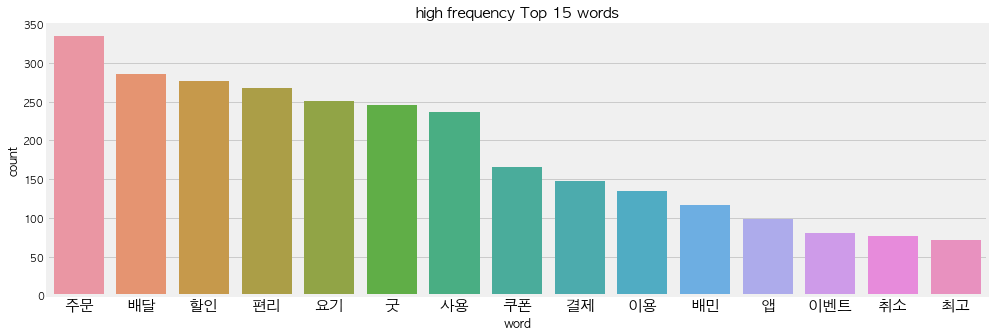

In [44]:
all_rating_word_count_df_new = get_dataframe_from_noun_list(all_rating_extracted_user_comment_noun_list)
draw_graph(all_rating_word_count_df_new)

In [45]:
# Topic Modeling with gensim

def save_model_data(name, directory_name):
    directory_path = f'{os.getcwd()}{os.sep}lda_model{os.sep}{directory_name}'
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
    file_path = os.path.join(directory_path, name)

    return file_path


def load_model_data(name, directory_name):
    directory_path = f'{os.getcwd()}{os.sep}lda_model{os.sep}{directory_name}'
    file_path = os.path.join(directory_path, name)

    return file_path


class ReviewModeling:

    def __init__(self, topic_num=10, rating_type='all_rating'):
        self.topic_num = topic_num
        self.rating_type = rating_type

    def make_train_review_data_list(self, review_text_list):
        cleaned_articles = self._delete_single_word(review_text_list)
        high_frequency_words = self._get_high_frequency_words(cleaned_articles)
        data_list = self._filter_low_frequency_word(cleaned_articles, high_frequency_words)

        return data_list

    def make_lda_model(self, data_list):
        self._make_word_dictionary(data_list)
        self._make_doc_matrix(data_list)
        self._make_gensim_model()

    def make_lda_visualization(self):
        load_directory_name = f'{self.rating_type}'
        model_file_path = load_model_data('app_review_train_model.model', load_directory_name)
        model = LdaModel.load(model_file_path)
        
        dict_file_path = load_model_data('app_review_dict.dict', load_directory_name)
#         dict_file_path = f'lda_model{os.sep}{self.rating_type}{os.sep}app_review_dict.dict'
        dictionary = gensim.corpora.Dictionary.load(dict_file_path)
        
        corpus_file_path = load_model_data('app_review_corpus.mm', load_directory_name)
#         corpus_file_path = f'lda_model{os.sep}{self.rating_type}{os.sep}app_review_corpus.mm'
        corpus = gensim.corpora.MmCorpus(corpus_file_path)
        
        prepare_data = pyLDAvis.gensim.prepare(
            model, corpus, dictionary
        )

        html_file_name = f'{self.rating_type}_app_review_topic_modeling_visualization.html'
        lda_visualization(prepare_data, html_file_name)
        
        self._make_probability_graph(model)

    def _delete_single_word(self, article_list):
        article_num = 0
        for split_article in article_list:
            article_list[article_num] = list(filter(lambda x: len(x) >= 2, split_article))
            article_num += 1

        return article_list

    def _get_high_frequency_words(self, clean_text):
        article_words = Counter()
        for article in clean_text:
            article_words.update(article)

        common_words_set = article_words.most_common(10000)
        high_frequency_words_set = tuple(word for word, count in common_words_set)

        return high_frequency_words_set

    def _filter_low_frequency_word(self, article_list, high_frequency_words):
        article_num = 0
        compare_words_set = Counter(high_frequency_words)

        for article in article_list:
            count_result_list = []
            article_counter = Counter(article)
            count_result = article_counter & compare_words_set

            for word, value in count_result.items():
                count_result_list.append(word)
            article_list[article_num] = count_result_list
            article_num += 1

        return article_list

    def _make_word_dictionary(self, train_data):
        self.review_dictionary = corpora.Dictionary(train_data)
        
        directory_name = f'{self.rating_type}'
        review_dict_file_name = save_model_data('app_review_dict.dict', directory_name)
        self.review_dictionary.save(review_dict_file_name)

    def _make_doc_matrix(self, train_data):
        self.doc_matrix = []
        for doc in train_data:
            doc2bow_result = self.review_dictionary.doc2bow(doc)
            self.doc_matrix.append(doc2bow_result)
        
        directory_name = f'{self.rating_type}'
        doc_matrix_file_name = save_model_data('app_review_corpus.mm', directory_name)
        corpora.MmCorpus.serialize(doc_matrix_file_name, self.doc_matrix)

    def _make_gensim_model(self):
        review_lda = models.ldamodel.LdaModel
        model = review_lda(
            self.doc_matrix,
            num_topics=self.topic_num,
            id2word=self.review_dictionary,
            passes=100
        )
    
        directory_name = f'{self.rating_type}'
        model_file_name = save_model_data('app_review_train_model.model', directory_name)
        model.save(model_file_name)

        return model
    
    def _make_probability_graph(self, lda_model):
        fig = plt.figure(figsize=(20,30))
        number = self.topic_num
        image_file_name = f'{self.rating_type}_review_topic.png'
        for i in range(number):
            lda_model_dataframe=pd.DataFrame(lda_model.show_topic(i), columns=['term','prob']).set_index('term')

            plt.subplot(5,3,i+1)
            sns.barplot(x='prob', y=lda_model_dataframe.index, data=lda_model_dataframe, label='Cities', palette="GnBu_d")
            plt.xlabel('probability')

        plt.tight_layout()
#         plt.savefig(image_file_name) # 그림 파일로 저장
        plt.show()

In [46]:
def make_lda_model_with_reviews(news_text, topic_num=10, rating_type='all_rating'):
    # make a lda model from news and draw a topic modeling graph.
    data = ReviewModeling(topic_num, rating_type)
    train_data_set = data.make_train_review_data_list(news_text)
    data.make_lda_model(train_data_set)
    data.make_lda_visualization()

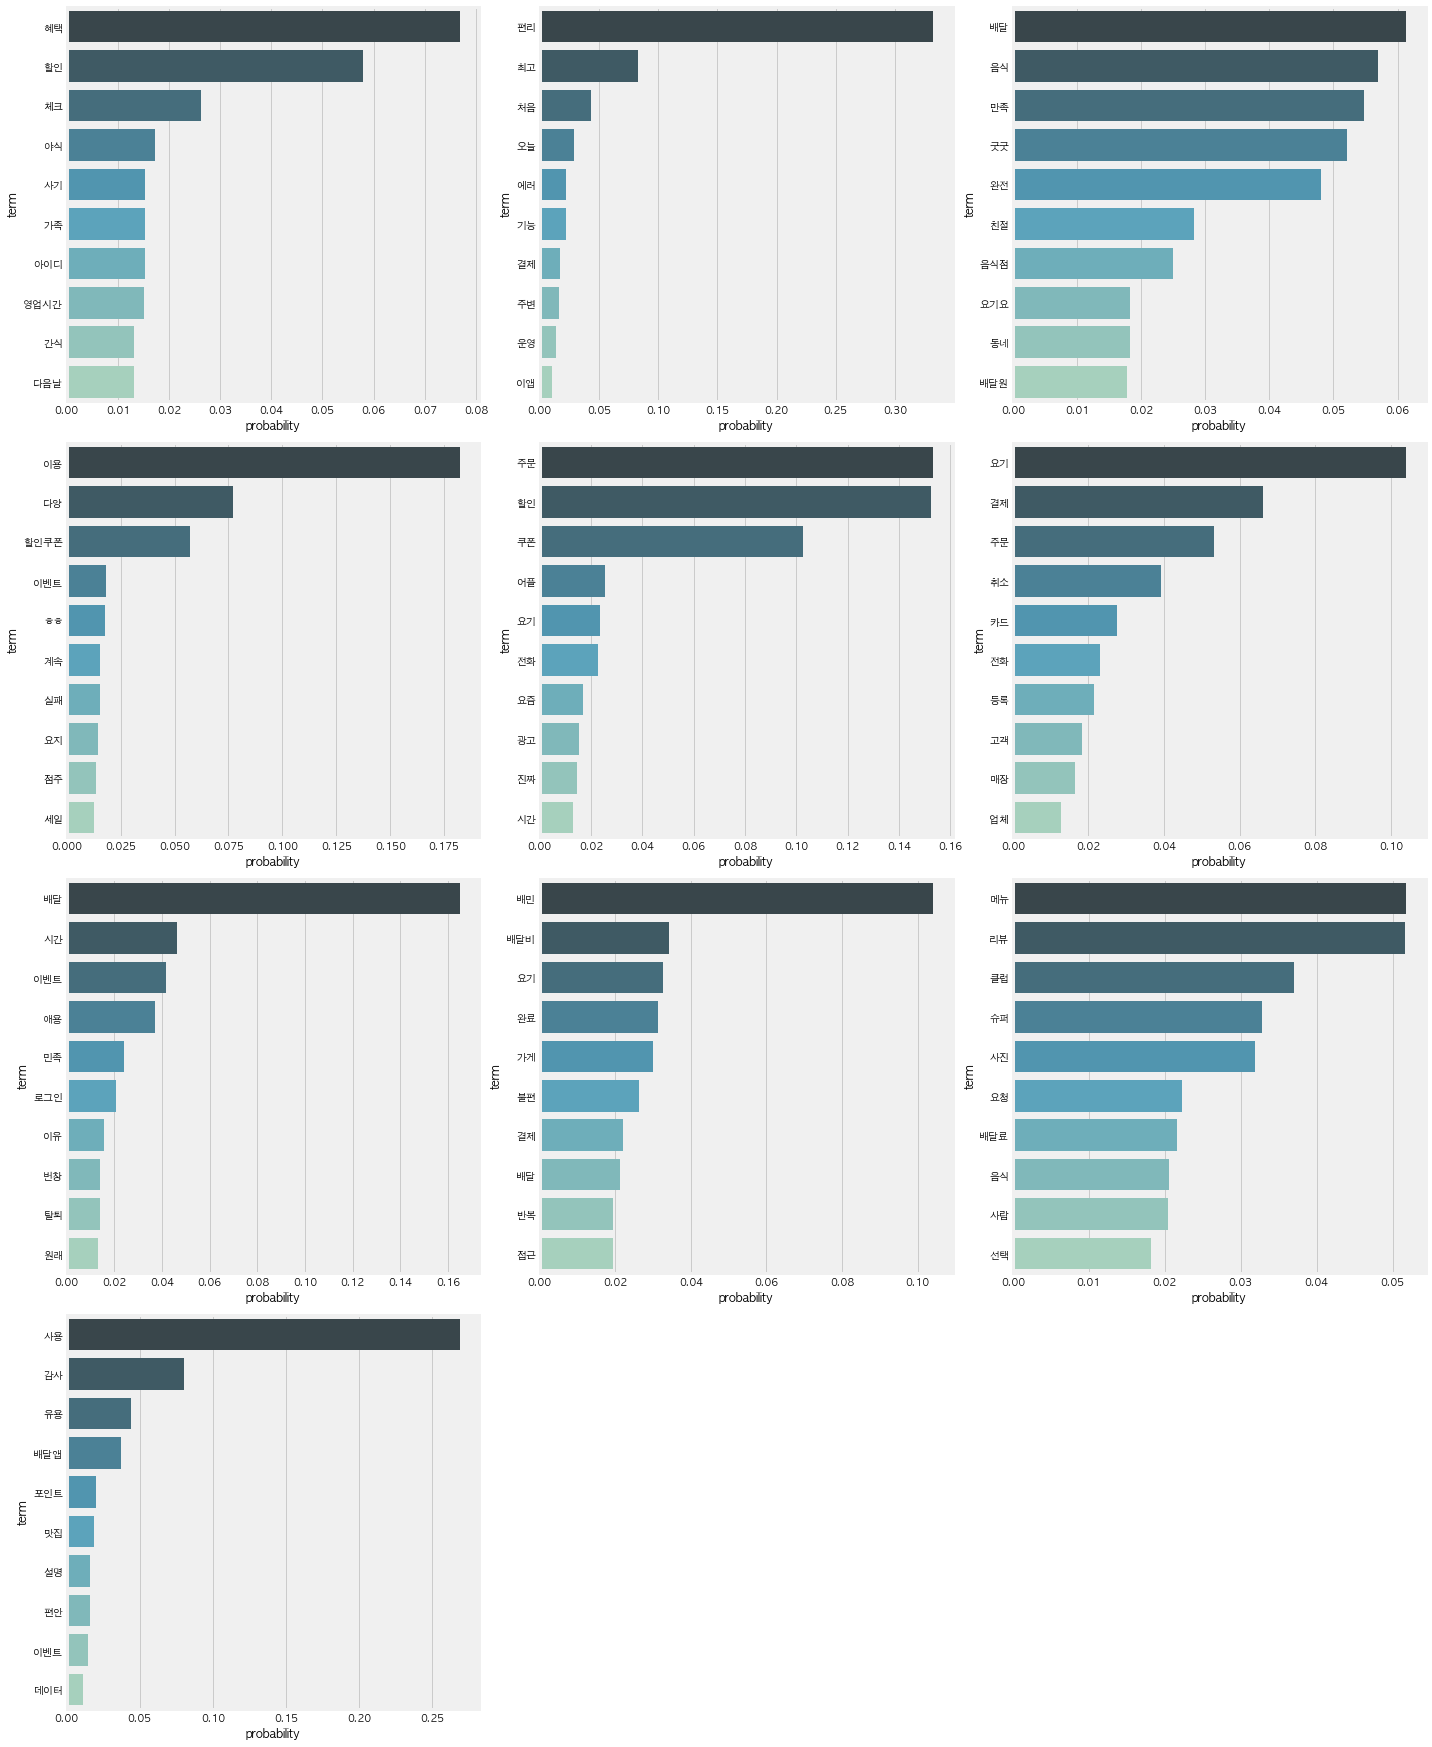

In [47]:
# run Topic modeling
make_lda_model_with_reviews(all_rating_extracted_user_comment_noun_list, 10, 'all_rating')

### display topics

In [53]:
def display_topics(app_rating):
    dictionary_file_path = f'lda_model{os.sep}{app_rating}{os.sep}app_review_dict.dict'
    corpus_file_path = f'lda_model{os.sep}{app_rating}{os.sep}app_review_corpus.mm'
    model_file_path = f'lda_model{os.sep}{app_rating}{os.sep}app_review_train_model.model'
    
    review_dictionary = gensim.corpora.Dictionary.load(dictionary_file_path)
    review_corpus = gensim.corpora.MmCorpus(corpus_file_path)
    review_lda = gensim.models.ldamodel.LdaModel.load(model_file_path)
    
    review_prep = pyLDAvis.gensim.prepare(review_lda, review_corpus, review_dictionary)
    
    return review_prep
    
review_prep = display_topics('all_rating')
pyLDAvis.display(review_prep)

### 별점 2점 이하일 경우에 대한 분석

In [54]:
# get user_comment_noun_list of low rating reviews

low_rating_user_comment_list = arranged_user_review_df[arranged_user_review_df['user_app_rating'] <= 2]['user_comment'].tolist()
low_rating_extracted_user_comment_noun_list = execute_khaiii(low_rating_user_comment_list)

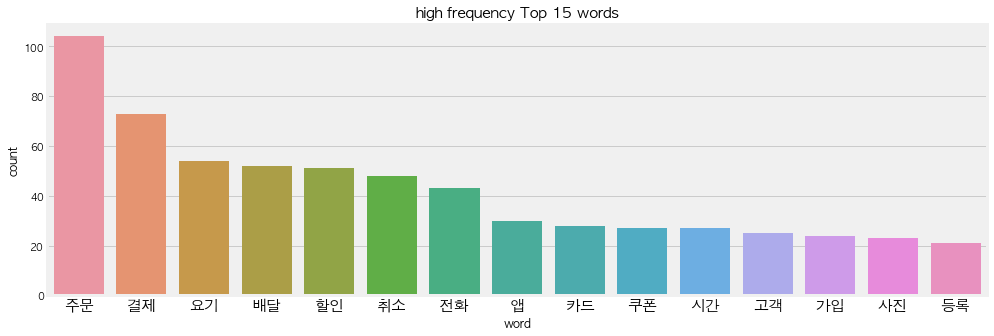

In [55]:
low_rating_word_count_df_new = get_dataframe_from_noun_list(low_rating_extracted_user_comment_noun_list)
draw_graph(low_rating_word_count_df_new)

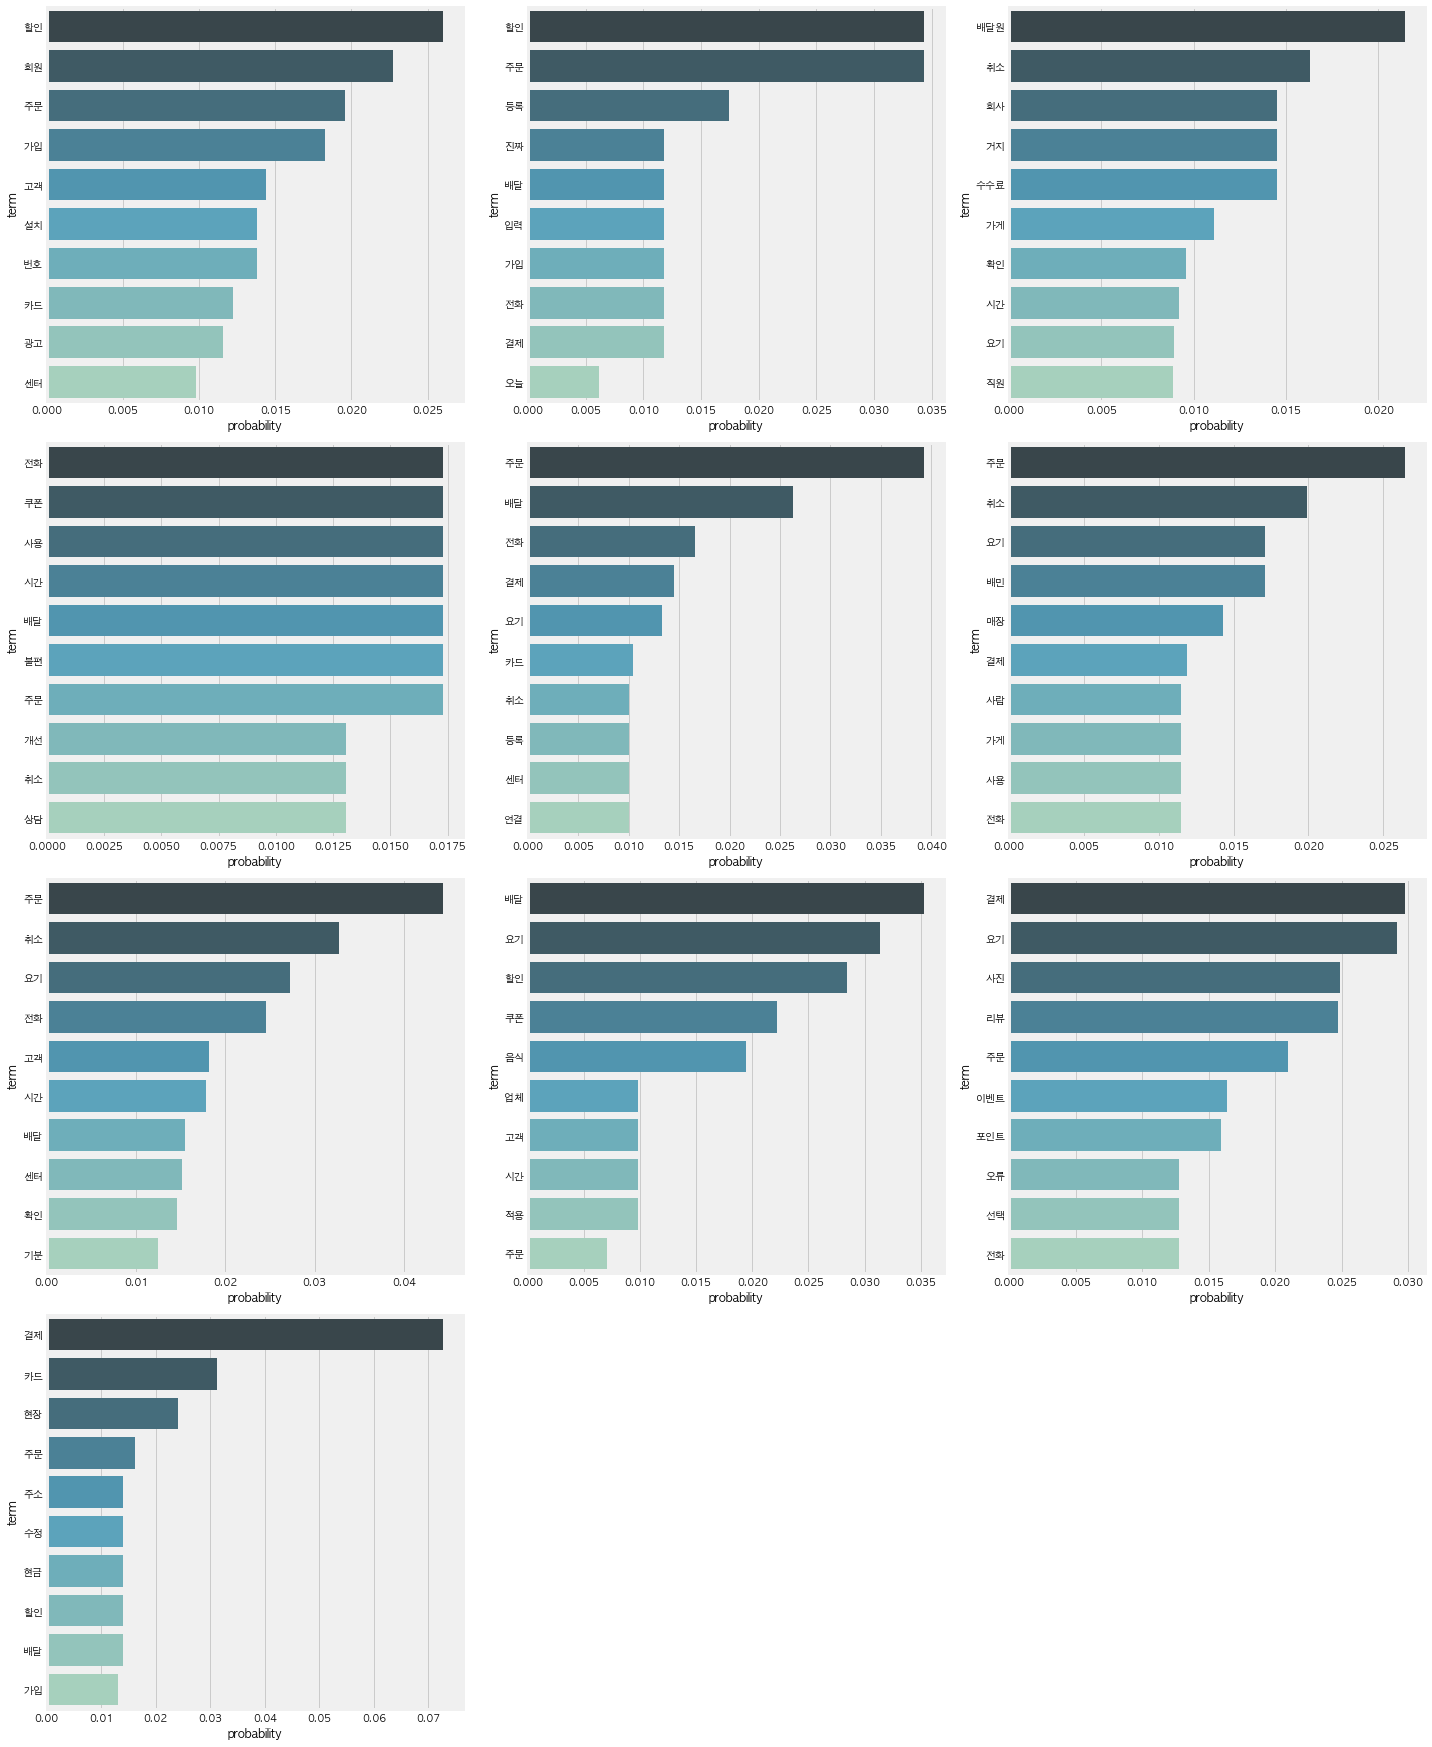

In [56]:
# run Topic modeling

make_lda_model_with_reviews(low_rating_extracted_user_comment_noun_list, 10, 'low_rating')

In [57]:
def display_topics(app_rating):
    dictionary_file_path = f'lda_model{os.sep}{app_rating}{os.sep}app_review_dict.dict'
    corpus_file_path = f'lda_model{os.sep}{app_rating}{os.sep}app_review_corpus.mm'
    model_file_path = f'lda_model{os.sep}{app_rating}{os.sep}app_review_train_model.model'
    
    review_dictionary = gensim.corpora.Dictionary.load(dictionary_file_path)
    review_corpus = gensim.corpora.MmCorpus(corpus_file_path)
    review_lda = gensim.models.ldamodel.LdaModel.load(model_file_path)
    
    review_prep = pyLDAvis.gensim.prepare(review_lda, review_corpus, review_dictionary)
    
    return review_prep
    
review_prep = display_topics('low_rating')
pyLDAvis.display(review_prep)